In [1]:
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, load_digits
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision.transforms.functional import rotate
from scipy import ndimage

In [2]:
   """ 
    def negative_log_likelihood_loss(self, output, Z, S):    
        loss = 0
        for i in range(self.input_size):
            loss += (Z[i]**2)/2
            for l in range(self.blocks):
                for j in range(self.skip_connection_dimension + 1, self.input_size):
                    loss -= np.log(S[l][j]) * Z[l][i][1:self.skip_connection_dimension]
        return torch.tensor(loss / self.input_size, requires_grad=True)
                           """

' \n def negative_log_likelihood_loss(self, output, Z, S):    \n     loss = 0\n     for i in range(self.input_size):\n         loss += (Z[i]**2)/2\n         for l in range(self.blocks):\n             for j in range(self.skip_connection_dimension + 1, self.input_size):\n                 loss -= np.log(S[l][j]) * Z[l][i][1:self.skip_connection_dimension]\n     return torch.tensor(loss / self.input_size, requires_grad=True)\n                        '

In [12]:
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks
        self.skip_connection_dimension = int(np.floor(input_size / 2))
        self.transform_dimension = int(input_size - self.skip_connection_dimension)
        
        self.scalling_coefficient_network = nn.ModuleList([nn.Sequential(
            *[nn.Linear(self.skip_connection_dimension, self.hidden_size),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.transform_dimension),
              nn.Tanh()]
        ) for l in range(self.blocks)])
        
        self.translation_coefficient_network = nn.ModuleList([nn.Sequential(
            *[nn.Linear(self.skip_connection_dimension, self.hidden_size),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.hidden_size),
              nn.ReLU(),
              nn.Linear(self.hidden_size, self.transform_dimension)]
        ) for l in range(self.blocks)])
    
    def decode(self, Z, Qs):
        Qs = list(reversed(Qs))
        reversed_scalling_coefficient_network = list(reversed(self.scalling_coefficient_network))
        revesed_translation_coefficient_network = list(reversed(self.translation_coefficient_network))
        X_previous = Z
        for l in range(self.blocks):
            X_skip = X_previous[:, :self.skip_connection_dimension]
            X_transform = X_previous[:, self.skip_connection_dimension:]
            s_tilde = reversed_scalling_coefficient_network[l](X_skip)
            s = torch.exp(-s_tilde)
            t = reversed_translation_coefficient_network[l](X_skip)
            X_transformed = torch.mul(X_transform - t, s)
            X_previous = torch.cat((X_skip, X_transformed), axis=1)
            if l < self.blocks - 1:
                X = torch.tensor(X_previous.detach().numpy() @ Qs[l].T)
                X_previous = X
        return X_previous
            

    
    def encode(self, X):
        Z_previous = X
        log_det = 0
        random_Qs = []
        for l in range(self.blocks):
            Z_skip = Z_previous[:, :self.skip_connection_dimension]
            Z_transform = Z_previous[:, self.skip_connection_dimension:]
            s_tilde = self.scalling_coefficient_network[l](Z_skip)
            s = torch.exp(s_tilde)
            t = self.translation_coefficient_network[l](Z_skip)
            Z_transformed = torch.mul(Z_transform, s) + t
            Z_previous = torch.cat((Z_skip, Z_transformed), axis=1)
            
            if l < self.blocks - 1:
                random_matrix = np.random.randn(self.input_size, self.input_size)
                random_Q = np.linalg.qr(random_matrix)[0]
                random_Q = random_Q.astype(np.float32)
                random_Qs.append(random_Q)
                Z = torch.tensor(Z_previous.detach().numpy() @ random_Q )
                Z_previous = Z
            log_det += torch.sum(s_tilde)
    
        return Z_previous, log_det, random_Qs

            
    
    def train_inn(self, X_train,  ts_size, epochs, lr=0.001, batch_size=128):
           # assert ts_size % batch_size == 0
           # assert batch_size % 2 == 0
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            losses = []
            for epoch in range(epochs):
                indices = torch.randperm(len(X_train))[:ts_size]
                X_train = X_train[indices]
                #Z, log_det, _ = self.encode(X_train)
                #loss = sum((torch.square(Z) / 2) - log_det).mean()
            
               
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                #losses.append(loss.detach().numpy())

                for batch in range(0, ts_size - batch_size, batch_size):
                    X_batch = X_train[batch : batch + batch_size]
                    Z, log_det, _ = self.encode(X_batch)
                    loss = torch.sum(torch.mul(Z, Z) / 2 - log_det).mean()
                    losses.append(loss.detach().numpy())
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()


            return self, np.array(losses)

        
        

In [4]:
def import_data(noise=0, random_state=1, shuffle=True, n_test=0.5, name="moons", n_samples = 2000):
    if name == "moons":
        data, _ = make_moons(noise=noise, random_state=random_state, shuffle=shuffle, n_samples=n_samples)
        X_train, X_test= train_test_split(data, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), None, None

    elif name == "digits":
        data, labels = load_digits(return_X_y = True)
        data = data.reshape((len(data), -1))
        noise =  np.random.normal(0, noise * data.max(), data.shape)
        X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(Y_train), torch.FloatTensor(Y_test)

In [5]:
X_train, X_test, Y_train, Y_test = import_data(noise=0.1, n_test=0.5,  name="moons")

In [ ]:
nvp, losses = RealNVP(2, 15, 6).train_inn(X_train, 1024, 150)

In [ ]:
plt.plot(losses)

In [10]:
Z,_, Qs = nvp.encode(X_test)
reconstruced = nvp.decode(Z, Qs)
reconstruced = reconstruced.detach().numpy()
Z = Z.detach().numpy()

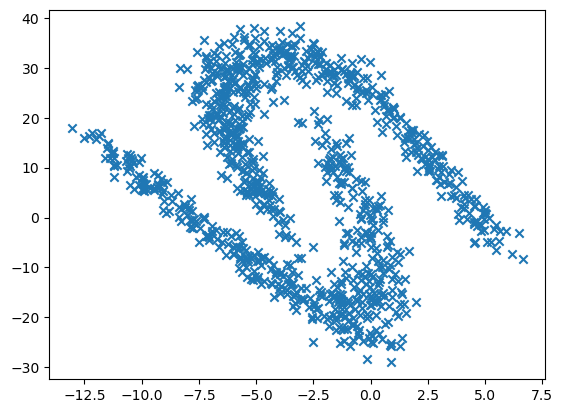

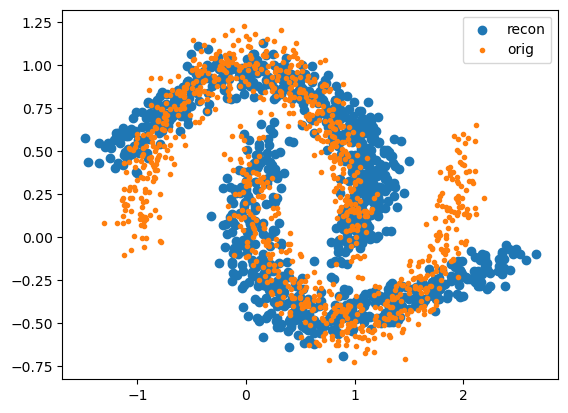

In [11]:
#plt.imshow(X_test[0].reshape(8, 8))
#plt.figure()
#plt.imshow(Z[0].reshape(8,8))
#plt.figure()
#plt.imshow(reconstruced[0].reshape(8,8))
plt.scatter(Z[:, 0], Z[:, 1], label="Z", marker="x")
plt.figure()
plt.scatter(reconstruced[:, 0], reconstruced[:, 1], label="recon")
plt.scatter(X_test[:, 0], X_test[:, 1], label="orig", marker=".")
plt.legend()